# 1.0 Becker Data Modelling XGBoost  
notebook: 1.1-becker-data-modelling_XGBoost.ipynb

author: Jonathan Becker  

**Updated:** 2025-11-28  
**Purpose:** Train XGBoost on concatenated dataset using preprocessing pipeline from 1.3.  
**Summary:** This notebook prepares the concatenated dataset, trains the model, and evaluates its performance. It also explores parameter optimization to improve the model’s accuracy and robustness.




In [24]:
# imports 
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../../library')
print(os.path.isfile('../../library/gc_storage.py'))
import gc_storage
from joblib import load,dump

from google.cloud import storage

True


In [25]:
# pipeline from 1.3-leibold-data-modelling_randomForest 
# visualization
import matplotlib.pyplot as plt
import seaborn as sns


# pipeline compatibel classes
from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import RearrangeCatCols             # bundle veh classes together to higher-tier classes
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation

# imputer
from sklearn.impute import SimpleImputer

# scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# encoder
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder
import category_encoders
from category_encoders.utils import BaseEncoder



# train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV 

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.over_sampling import SMOTE

# model classifier
from xgboost import XGBClassifier

# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time

In [27]:
# init Google Cloud storage
bucket_name='sep25-bds-road-accidents'
key_path='../../auth/fiery-glass-478009-t8-18a81c8cbe63.json'

bucket = gc_storage.init_bucket( bucket=bucket_name,
                                 json_key_path=key_path )
# listing joblibs
gc_storage.list_bucket( bucket=bucket,
                        remote_folder='2_preprocessing' )
# load concatenated dataframe from google cloud storage
df = gc_storage.download( bucket=bucket,
                                  remote_path='2_preprocessing/1.2-leibold-data-preprocessing_concat.joblib')

if 'ind_severity' not in df.columns:
    raise KeyError("Column 'ind_severity' not found in df")

Initialized sep25-bds-road-accidents
data/processed/2_preprocessing/0.1-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.2-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.3-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.4-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/1.0-becker-data-preprocessing_usagers.joblib
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_vehicles.joblib
data/processed/2_preprocessing/1.0-simmler-data-preprocessing_accidents.joblib
data/processed/2_preprocessing/1.0.1-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/1.0.2-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/1.0.3-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/1.1-becker-data-preprocessing_usagers.joblib
data/processed/2_preprocessing/1.1-leibold-data-preprocessing_concat.joblib
data/processed/2_preprocessing/1.1-leibo

In [28]:
# -------------------------------------------------------------------------------------------------
# data split
# -------------------------------------------------------------------------------------------------
# Separate features and target
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (610132, 43)
y_train shape: (610132,)
X_test shape: (152534, 43)
y_test shape: (152534,)


In [5]:
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict
missing_cat_cols = [col for col in cat_cols if col in X_train.columns and X_train[col].isna().any()] # Restrict to those with missing values

ohe_cols = cols_dict['oneHot_encoder']


⚠️ Missing columns (ignored): ['loca_road_count']


In [6]:
# --pipeline from 1.3-leibold-data-modelling_randomForest --
# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
spline_hour = SplineTransformer(degree=3, knots=np.linspace(0, 23, num=6).reshape(-1, 1), extrapolation='periodic', include_bias=True)
spline_month = SplineTransformer(degree=3, knots=np.linspace(1, 12, num=4).reshape(-1, 1), extrapolation='periodic', include_bias=True)
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'),
    columns=["acc_municipality"]
)
# instantiate Scaler
scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),

    # imputing
    ("impute_quant", ConditionalMultiQuantImputer(
        quant_vars=["loca_max_speed", "loca_road_lanes"],
        cat_var="loca_road_cat"
    )),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),

    # aggregation
    ("aggregate", AggrLocaSplit(agg_features="max", agg_target="max")),
    ("remove_id_cols", RemoveIdCols(verbose=True)),

    # encoding & scaling
    ("rearrange_categories", RearrangeCatCols(verbose=True)),
    ("encode_scale", ColumnTransformer([
        ("spline_hour", spline_hour, ["acc_hour"]),
        ("spline_month", spline_month, ["acc_month"]),
        ("onehot", ohe_encoder, lambda X: [c for c in ohe_cols if c in X.columns]),
        ("catboost", catboost_encoder, ["acc_municipality"]),
        ("scale", scaler, cols_dict["quantitative"])
    ], remainder="passthrough"))
    
], verbose=True)


# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# Access the fitted aggregation step
aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error
y_train_piped = aggr_step.transform_y(X_train, y_train)
y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


[Pipeline] ....... (step 1 of 7) Processing remove_cols, total=   0.1s
[Pipeline] ...... (step 2 of 7) Processing impute_quant, total=  17.3s
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.
[Pipeline] ........ (step 3 of 7) Processing impute_cat, total=  17.9s
[Pipeline] ......... (step 4 of 7) Processing aggregate, total=   4.9s
[Pipeline] .... (step 5 of 7) Processing remove_id_cols, total=   0.0s
[Pipeline]  (step 6 of 7) Processing rearrange_categories, total=   0.1s
[Pipeline] ...... (step 7 of 7) Processing encode_scale, total=   3.0s
⏱️ Preprocessing Pipeline fit completed in 1.50 minutes


In [29]:
# get feature names from the fitted ColumnTransformer inside the pipeline
names = preprocessing_pipeline.named_steps['encode_scale'].get_feature_names_out()

# create DataFrames so XGBoost keeps column names
X_tr_df = pd.DataFrame(X_train_piped, columns=names)
X_te_df = pd.DataFrame(X_test_piped, columns=names)



In [30]:
# use DataFrames with feature names for display and checks
print("X_tr_df shape:", X_tr_df.shape)
print("y_train_piped shape:", y_train_piped.shape)

# show first 2 rows with column names
display(X_tr_df.head(2))

# check that feature name count matches transformed array (sanity)
assert X_tr_df.shape[1] == X_train_piped.shape[1], "Number of columns mismatch between DataFrame and transformed array"

# check alignment: number of rows must match
assert X_tr_df.shape[0] == len(y_train_piped), "Row count mismatch between X_tr_df and y_train_piped"

# target distribution (pandas gives nicer output)
print("Class counts (absolute):")
print(pd.Series(y_train_piped).value_counts().sort_index())

print("Class distribution (relative %):")
print(pd.Series(y_train_piped).value_counts(normalize=True).sort_index() * 100)

X_tr_df shape: (564874, 155)
y_train_piped shape: (564874,)


,spline_hour__acc_hour_sp_0,spline_hour__acc_hour_sp_1,spline_hour__acc_hour_sp_2,spline_hour__acc_hour_sp_3,spline_hour__acc_hour_sp_4,spline_month__acc_month_sp_0,spline_month__acc_month_sp_1,spline_month__acc_month_sp_2,onehot__acc_ambient_lightning_1.0,onehot__acc_ambient_lightning_2.0,...,remainder__loca_road_view_4.0,remainder__loca_accident_0,remainder__loca_accident_1,remainder__loca_accident_2,remainder__loca_accident_3,remainder__loca_accident_4,remainder__loca_accident_5,remainder__loca_accident_6,remainder__loca_accident_7,remainder__loca_road_count
0,0.079888,0.624545,0.293855,0.001712,0.0,0.330078,0.602429,0.067493,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.079888,0.624545,0.293855,0.001712,0.0,0.330078,0.602429,0.067493,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Class counts (absolute):
y
1    233622
2    229468
3     86943
4     14841
Name: count, dtype: int64
Class distribution (relative %):
y
1    41.358250
2    40.622865
3    15.391574
4     2.627312
Name: proportion, dtype: float64


- ERROR: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [1 2 3 4]
Train time (s): 0.1 > first output. so i had to map the labels from 1-4 to 0-3

In [33]:
non_numeric = [c for c in X_tr_df.columns if X_tr_df[c].dtype == 'object' or not pd.api.types.is_numeric_dtype(X_tr_df[c])]
print("Non-numeric columns detected:", non_numeric)
# Convert object-like columns to numeric, impute any resulting NaNs with training medians, cast to float
obj_cols = [c for c in X_tr_df.columns if X_tr_df[c].dtype == 'object']

for c in obj_cols:
    # convert strings to numeric; invalid parsing -> NaN
    X_tr_df[c] = pd.to_numeric(X_tr_df[c], errors='coerce')
    X_te_df[c] = pd.to_numeric(X_te_df[c], errors='coerce')

# impute NaNs with training medians and apply same medians to test set
nan_cols = X_tr_df.columns[X_tr_df.isna().any()].tolist()
if nan_cols:
    med = X_tr_df[nan_cols].median()
    X_tr_df[nan_cols] = X_tr_df[nan_cols].fillna(med)
    X_te_df[nan_cols] = X_te_df[nan_cols].fillna(med)

# ensure all columns are float for XGBoost
X_tr_df = X_tr_df.astype(float)
X_te_df = X_te_df.astype(float)

Non-numeric columns detected: ['spline_hour__acc_hour_sp_0', 'spline_hour__acc_hour_sp_1', 'spline_hour__acc_hour_sp_2', 'spline_hour__acc_hour_sp_3', 'spline_hour__acc_hour_sp_4', 'spline_month__acc_month_sp_0', 'spline_month__acc_month_sp_1', 'spline_month__acc_month_sp_2', 'onehot__acc_ambient_lightning_1.0', 'onehot__acc_ambient_lightning_2.0', 'onehot__acc_ambient_lightning_3.0', 'onehot__acc_ambient_lightning_4.0', 'onehot__acc_ambient_lightning_5.0', 'onehot__acc_urbanization_level_1', 'onehot__acc_urbanization_level_2', 'onehot__acc_intersection_1.0', 'onehot__acc_intersection_2.0', 'onehot__acc_intersection_3.0', 'onehot__acc_intersection_4.0', 'onehot__acc_intersection_5.0', 'onehot__acc_intersection_6.0', 'onehot__acc_intersection_7.0', 'onehot__acc_intersection_8.0', 'onehot__acc_intersection_9.0', 'onehot__acc_atmosphere_1.0', 'onehot__acc_atmosphere_2.0', 'onehot__acc_atmosphere_3.0', 'onehot__acc_atmosphere_4.0', 'onehot__acc_atmosphere_5.0', 'onehot__acc_atmosphere_6.0'

In [34]:
# Map labels from 1-4 to 0-3 and retrain baseline XGBoost
y_train_mapped = y_train_piped - 1
y_test_mapped  = y_test_piped  - 1
# first baseline check with XGBoost
model = XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

t0 = time.time()
try:
    model.fit(X_tr_df, y_train_mapped)
except Exception as e:
    print("ERROR:", e)
else:
    y_pred = model.predict(X_te_df)
    print("ACC:", round(accuracy_score(y_test_mapped, y_pred), 4))
    print("F1_macro:", round(f1_score(y_test_mapped, y_pred, average='macro'), 4))
print("Train time (s):", round(time.time() - t0, 1))


/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [21:07:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ACC: 0.6761
F1_macro: 0.511
Train time (s): 11.4


- Metrics: Accuracy = 0.6761; Macro F1 = 0.511 — both ..not quite well
- Insight: accuracy is moderate but lower Macro F1 shows uneven per-class performance.
- Next step: apply class weighting (sample_weights) and run RandomizedSearchCV to tune XGBoost hyperparameters.




In [35]:
# Randomized search for XGB multiclass (comments in English)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

# compute sample weights (inverse class frequency)
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_mapped)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_mapped)
sample_weight_map = {c: w for c, w in zip(classes, class_weights)}
sample_weights = np.array([sample_weight_map[y] for y in y_train_mapped])

# parameter distributions (reasonable defaults)
param_dist = {
    "n_estimators": randint(50, 400),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 5),
    "min_child_weight": randint(1, 10)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb = XGBClassifier(objective="multi:softprob", num_class=4, use_label_encoder=False, eval_metric="mlogloss", random_state=42, n_jobs=1)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=5,
    scoring='f1_macro',
    n_jobs=1,
    cv=cv,
    verbose=1,
    random_state=42
)

# run search (this may take time)
try:
    search.fit(X_tr_df, y_train_mapped, sample_weight=sample_weights)
except Exception as e:
    print("ERROR:", e)
else:
    print("BEST_PARAMS:", search.best_params_)
    print("BEST_SCORE:", round(search.best_score_, 4))


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [21:20:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [21:20:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [21:21:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [21:21:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fo

BEST_PARAMS: {'colsample_bytree': np.float64(0.9162213204002109), 'gamma': np.float64(1.0616955533913808), 'learning_rate': np.float64(0.06454749016213018), 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 363, 'subsample': np.float64(0.8099025726528951)}
BEST_SCORE: 0.5878


- **Best params:** `n_estimators=363`, `max_depth=7`, `learning_rate≈0.0645`, `subsample≈0.81`, `colsample_bytree≈0.92`, `gamma≈1.06`, `min_child_weight=1`
- **Best score:** Macro F1 = **0.5878** (improved vs. baseline).

- model improved slightly



In [36]:
# apply best params, fit and evaluate (uses your variable names)
model_final = XGBClassifier(
    tree_method='hist',
    n_jobs=1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    objective="multi:softprob",
    num_class=4,
    n_estimators=363,
    max_depth=7,
    learning_rate=0.06454749016213018,
    subsample=0.8099025726528951,
    colsample_bytree=0.9162213204002109,
    gamma=1.0616955533913808,
    min_child_weight=1
)

# fit (use sample_weights if defined)
sw = globals().get('sample_weights', None)
model_final.fit(X_tr_df, y_train_mapped, sample_weight=sw, verbose=False)

# predict and print concise metrics
y_pred = model_final.predict(X_te_df)
print("ACC:", round(accuracy_score(y_test_mapped, y_pred), 4))
print("F1_macro:", round(f1_score(y_test_mapped, y_pred, average='macro'), 4))




/opt/homebrew/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [21:55:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ACC: 0.6286
F1_macro: 0.52


In [ ]:
# Print per-class precision/recall/f1 


try:
    y_pred = model_final.predict(X_te_df)
except Exception as e:
    print("ERROR:", e)
else:
    report = classification_report(y_test_mapped, y_pred, digits=4)
    print(report)


              precision    recall  f1-score   support

           0     0.7559    0.7927    0.7739     62183
           1     0.7217    0.5210    0.6052     60894
           2     0.4011    0.4699    0.4328     22786
           3     0.1713    0.6191    0.2683      3825

    accuracy                         0.6286    149688
   macro avg     0.5125    0.6007    0.5200    149688
weighted avg     0.6731    0.6286    0.6404    149688



- class 3 has very low precision score. and a recall of 0.619 > many false positives
- class 2 also weak score. it struggeles to separate the classes with 0.40 precision, and recall of 0.47
- class 1 has good way better precision score but a low recall. 
- class 0 shows the best scores for now. 
- takeaway: the model favors the majority classes. 

In [39]:
# get xgboost importance dict
imp_dict = model_final.get_booster().get_score(importance_type='gain')

# try to obtain real feature names (in this order)
if 'feat_names' in globals() and len(feat_names) == X_te_df.shape[1]:
    names = list(feat_names)
elif hasattr(X_tr_df, "columns"):
    names = list(X_tr_df.columns)
else:
    try:
        if 'preprocessor' in globals():
            names = preprocessor.get_feature_names_out().tolist()
        elif 'pipeline' in globals() and 'preprocessor' in pipeline.named_steps:
            names = pipeline.named_steps['preprocessor'].get_feature_names_out().tolist()
    except Exception:
        names = None

# if still not found, warn and stop (prevents guessing)
if names is None:
    print("ERROR: real feature names not found. Provide 'feat_names', a DataFrame X_train_piped, or a fitted preprocessor/pipeline.")
else:
    # build mapping from xgboost keys to real names
    mapped = []
    for key, val in imp_dict.items():
        real = key
        if key.startswith('f'):
            idx = None
            try:
                idx = int(key[1:])            # handles 'f65'
            except Exception:
                try:
                    idx = int(key.split('_',1)[1])  # handles 'f_65'
                except Exception:
                    idx = None
            if idx is not None and 0 <= idx < len(names):
                real = names[idx]
        mapped.append((key, real, float(val)))

    # include features with zero importance
    existing_keys = {m[0] for m in mapped}
    for i, n in enumerate(names):
        k1 = f"f{i}"
        k2 = f"f_{i}"
        if k1 not in existing_keys and k2 not in existing_keys:
            mapped.append((k1, n, 0.0))

    # sort by importance and print top 20 with real names
    mapped_sorted = sorted(mapped, key=lambda x: x[2], reverse=True)
    for rank, (key, real, imp) in enumerate(mapped_sorted[:20], start=1):
        print(f"{rank:2d}. {real}  (key: {key}) -> {imp:.6f}")

    

 1. onehot__ind_secu1_1.0  (key: onehot__ind_secu1_1.0) -> 396.987762
 2. onehot__acc_urbanization_level_1  (key: onehot__acc_urbanization_level_1) -> 254.823242
 3. onehot__veh_fixed_obstacle_0  (key: onehot__veh_fixed_obstacle_0) -> 194.765717
 4. onehot__veh_moving_obstacle_1  (key: onehot__veh_moving_obstacle_1) -> 131.700150
 5. onehot__acc_urbanization_level_2  (key: onehot__acc_urbanization_level_2) -> 114.473175
 6. remainder__loca_traffic_circul_2  (key: remainder__loca_traffic_circul_2) -> 88.231003
 7. onehot__acc_collision_type_1.0  (key: onehot__acc_collision_type_1.0) -> 83.663872
 8. onehot__ind_secu1_8.0  (key: onehot__ind_secu1_8.0) -> 81.696075
 9. onehot__ind_sex_2  (key: onehot__ind_sex_2) -> 74.080330
10. onehot__veh_moving_obstacle_2  (key: onehot__veh_moving_obstacle_2) -> 74.058075
11. onehot__ind_place_10  (key: onehot__ind_place_10) -> 64.595291
12. onehot__ind_secu1_3.0  (key: onehot__ind_secu1_3.0) -> 63.523537
13. onehot__veh_moving_obstacle_0  (key: onehot

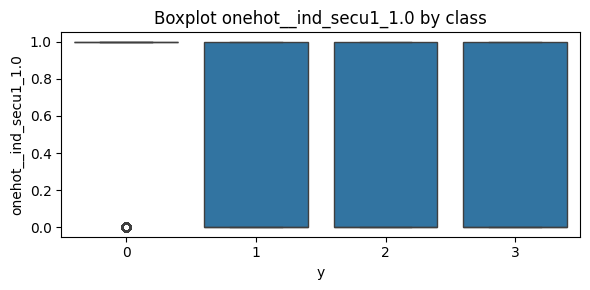

In [ ]:
top_feature = mapped_sorted[0][1]   # first real feature name from mapped_sorted
f = top_feature



plt.figure(figsize=(6,3))
if pd.api.types.is_numeric_dtype(X_tr_df[f]):
    sns.boxplot(x=y_train_mapped, y=X_tr_df[f])
    plt.title(f"Boxplot {f} by class")
else:
    ct = pd.crosstab(X_tr_df[f], y_train_mapped, normalize='columns')
    ct.plot(kind='bar', stacked=True, figsize=(6,3))
    plt.title(f"Distribution {f} by class")
plt.tight_layout()
plt.show()

In [44]:


top_n = 10
top_features = [real for (_, real, _) in mapped_sorted][:top_n]

import pandas as pd

for f in top_features:
    print(f"\n=== Feature: {f} ===")
    # value counts (top 10)
    try:
        vc = X_tr_df[f].value_counts(dropna=False).head(10)
        print("Value counts (top 10):")
        print(vc.to_string())
    except KeyError:
        print("Column not found in X_tr_df")

    # share by class (normalized by column = share of each class that has the feature value)
    try:
        ct = pd.crosstab(X_tr_df[f], y_train_mapped, normalize='columns')
        print("\nShare by class (columns normalized):")
        print(ct.head(10).to_string())
    except Exception as e:
        print("Crosstab failed:", e)




=== Feature: onehot__ind_secu1_1.0 ===
Value counts (top 10):
onehot__ind_secu1_1.0
1.0    338973
0.0    225901

Share by class (columns normalized):
y                             0         1         2        3
onehot__ind_secu1_1.0                                       
0.0                    0.159801  0.532266  0.654406  0.64241
1.0                    0.840199  0.467734  0.345594  0.35759

=== Feature: onehot__acc_urbanization_level_1 ===
Value counts (top 10):
onehot__acc_urbanization_level_1
0.0    349687
1.0    215187

Share by class (columns normalized):
y                                        0         1         2         3
onehot__acc_urbanization_level_1                                        
0.0                               0.653624  0.659578  0.468824  0.328347
1.0                               0.346376  0.340422  0.531176  0.671653

=== Feature: onehot__veh_fixed_obstacle_0 ===
Value counts (top 10):
onehot__veh_fixed_obstacle_0
1.0    473552
0.0     91322

Share by cla

y                             0         1         2        3
onehot__ind_secu1_1.0                                       
0.0                    0.159801  0.532266  0.654406  0.64241
1.0                    0.840199  0.467734  0.345594  0.35759

for class 0 there are 84% in 1.0 whereas class 1,2 and 3 have 1 with 35-46%. 
ind_secu1_1.0 was seatbelt. 

urbanization_level_1 also shows interesting information. from class 0 to 3 the amount of 1.0 increases


# SHAP 
- to explore the blackbox of the model and explain the differences between RF and xgBoost i implement SHAP for better interpretation of the results above. 
- first try interupted at 'PermutationExplainer explainer:  10%|█         | 15471/149688 [57:46<8:22:05,  4.46it/s] ' due to computation time
- reduced size of X_te_df to reduce computation time



PermutationExplainer explainer: 501it [01:55,  3.95it/s]                         
/var/folders/wg/yhq9d1yx1t1cjky0l7l0d6040000gn/T/ipykernel_51300/378368291.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values[:, top20_idx], X_sample.iloc[:, top20_idx], plot_type="bar")


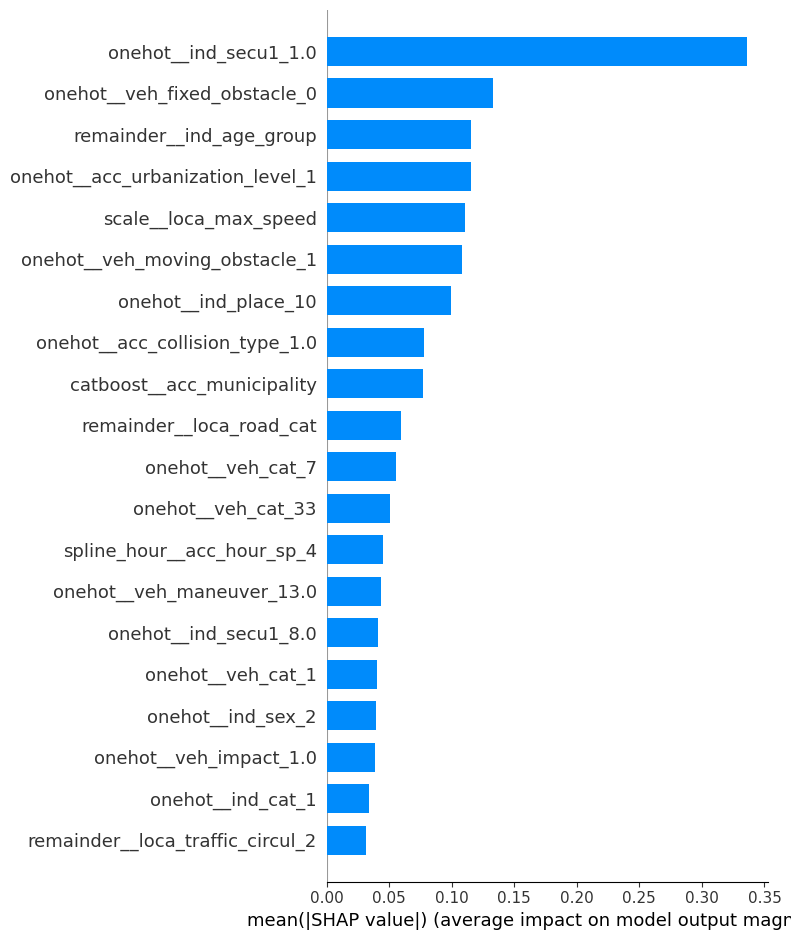

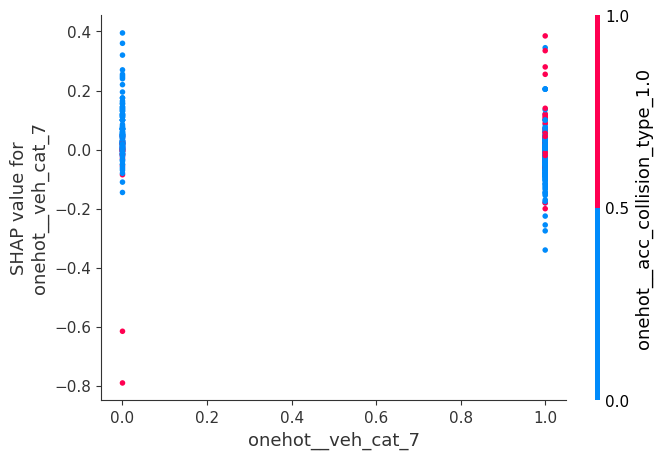

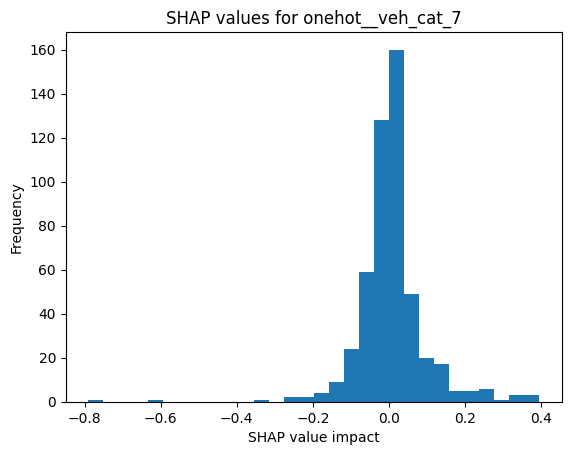

In [53]:
import shap

# use a sample of test data for SHAP to reduce computation time
X_sample = X_te_df.sample(500, random_state=42)
explainer = shap.Explainer(model_final.predict, shap.sample(X_tr_df, 100))
shap_values = explainer(X_sample)

# top 20 features by mean absolute SHAP value
mean_abs_shap = np.abs(shap_values.values).mean(0)
top20_idx = np.argsort(mean_abs_shap)[-20:]
shap.summary_plot(shap_values.values[:, top20_idx], X_sample.iloc[:, top20_idx], plot_type="bar")

# force plot for a single prediction
shap.force_plot(shap_values.base_values[0], shap_values.values[0,:], X_sample.iloc[0,:])

# Dependence Plot 
shap.dependence_plot("onehot__veh_cat_7", shap_values.values, X_sample)

# distribution of SHAP values for a specific feature
feature_index = X_sample.columns.get_loc("onehot__veh_cat_7")
plt.hist(shap_values.values[:, feature_index], bins=30)
plt.title("SHAP values for onehot__veh_cat_7")
plt.xlabel("SHAP value impact")
plt.ylabel("Frequency")
plt.show()
